In [1]:
# This is the final main program in the pipeline, although it is mostly devoted to displays.
# This program actually takes the corrections generated and applies them to real data.

In [2]:
import numpy as np
from numpy import loadtxt
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
from astropy.table import Table
import os
from os import listdir
import scipy as sc
import treecorr

In [3]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel/' # Directory containing real stars
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'
files = os.listdir(dirStars)
res = 4096
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R']

In [4]:
validPix = fitsio.read(dirTrain + 'Valid_'+str(res)+'_Pixels.fits')['PIXEL']

In [5]:
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

In [6]:
PIX = np.empty(7, dtype = list)
for i in np.arange(len(PIX)):
    PIX[i] = []
FOREGROUND = []
BADREGIONS = []
FOOTPRINT = []
CLASS = []

# One obvious different with this data set compared to the balrog data is that by assumption each data point is a detection.
for file in files:
    starData = fitsio.read(dirStars + file, columns = usedCols)
    FOREGROUND = starData[usedCols[1]]
    BADREGIONS = starData[usedCols[2]]
    FOOTPRINT = starData[usedCols[3]]
    CLASS = starData[usedCols[4]]
    GMAG = starData[usedCols[5]]
    RMAG = starData[usedCols[6]]
    
    # This cut doesn't cut based on magnitude, just based on gold cuts and color cuts.
    blueCut = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (CLASS <= 1) & 
                      (CLASS >= 0) &
                      ((GMAG - RMAG) <= 1) &
                      ((GMAG - RMAG) >= -0.3))[0]
    
    # This converts the pixels (given in 4096 resolution) to angles.
    theta, phi = hp.pix2ang(4096, starData[usedCols[0]][blueCut], nest = True, lonlat = True)
    
    # This converts the angles to 512 pixels and crops the GMAG to the appropriate level.
    allPIX = hp.ang2pix(res, theta, phi, nest = True, lonlat = True)
    allGMAG = GMAG[blueCut]
    
    # This trims to make sure we are on valid pixels.
    trimPIX = allPIX[np.where(pixCheck[allPIX])[0]]
    trimGMAG = allGMAG[np.where(pixCheck[allPIX])[0]]
    
    # This adds the appropriate pixels to each magnitude bin.
    PIX[0].extend(trimPIX[np.where(trimGMAG <= 20)[0]])
    PIX[1].extend(trimPIX[np.where((trimGMAG > 20) & (trimGMAG <= 22))[0]])
    PIX[2].extend(trimPIX[np.where((trimGMAG > 22) & (trimGMAG <= 23))[0]])
    PIX[3].extend(trimPIX[np.where((trimGMAG > 23) & (trimGMAG <= 24))[0]])
    PIX[4].extend(trimPIX[np.where((trimGMAG > 24) & (trimGMAG <= 25))[0]])
    PIX[5].extend(trimPIX[np.where((trimGMAG > 25) & (trimGMAG <= 26))[0]])
    PIX[6].extend(trimPIX[np.where(trimGMAG > 26)[0]])
    
for i in np.arange(len(PIX)):
    PIX[i] = np.array(PIX[i])

In [7]:
# This creates a pixel and detection array for each magnitude bin.
starPIX = np.empty(len(PIX), dtype = list)    
starDET = np.empty(len(PIX), dtype = list)

for i in np.arange(len(PIX)):
    # This simply has all of the pixels, one per star. Due to that there can be repeats.
    starPIXRepeats = PIX[i]

    # This sorts by the pixel in order to make following methods more efficient.
    sortInds = starPIXRepeats.argsort()
    starPIXRepeats = starPIXRepeats[sortInds[::1]]
    # starDETRepeats = np.zeros(len(starPIXRepeats))

    # These are indices that will be looping through the pixStar and starPix arrays in parallel.
    uniqInd = 0
    starInd = 0

    # This will be used to store the number of stars at each pixel.
    starPIXind = np.unique(starPIXRepeats) # The unique pixels, with no repeats.
    starDETind = np.zeros_like(starPIXind) # Will be used to store the number of detections at each pixel.

    while starInd < len(starPIXRepeats):
        if starPIXind[uniqInd] == starPIXRepeats[starInd]: # If the pixels match up in the arrays.
            starDETind[uniqInd] += 1                # Add one for the detection..
            starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
            # Since the last index of starPixRepeats and starPix are the same, starInd will increase the last time through 
            # the loop, making this the index that we must restrict in the while loop.
        else:
            uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
            
    starDET[i] = starDETind
    starPIX[i] = starPIXind

In [8]:
# While commented out, this would store the original maps for quicker use.

stars = np.zeros(12*(res**2))
stars[starPIX[0]] = starDET[0]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_<20_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[1]] = starDET[1]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_20-22_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[2]] = starDET[2]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_22-23_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[3]] = starDET[3]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_23-24_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[4]] = starDET[4]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_24-25_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[5]] = starDET[5]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_25-26_Original_Map.fits', overwrite = True)

stars = np.zeros(12*(res**2))
stars[starPIX[6]] = starDET[6]

my_table = Table()
my_table['PIXEL'] = validPix
my_table['SIGNAL'] = stars[validPix]
my_table.write(dirTrain + str(res) + 'Blue_>26_Original_Map.fits', overwrite = True)

In [13]:
# Reads in the corrections necessary to apply
corrections = []
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_<20_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_20-22_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_22-23_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_23-24_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_24-25_Corrections_Map.fits')['SIGNAL'])
corrections.append(fitsio.read(dirTrain + str(res) + '_Inter_Blue_25-26_Corrections_Map.fits')['SIGNAL'])
# corrections.append(fitsio.read(dirTrain + 'Inter_Blue_>26_Corrections_Map.fits')['SIGNAL'])
corrections = np.array(corrections)

In [14]:
# This makes a full original map. It adds in the stars from each magnitude bin.
origFullMap = np.full(12*(res**2), 0.0)
for i in np.arange(len(corrections)):
    origFullMap[starPIX[i]] += starDET[i]
origFullMap[~pixCheck] = hp.UNSEEN

In [15]:
# This makes a full corrected map. It adds stars times their correction from each magnitude bin.
fullMap = np.full(12*(res**2), 0.0)
for i in np.arange(len(corrections)):
    corrPerPix = np.full(12*(res**2), 1.0)
    corrPerPix[validPix] = corrections[i]
    fullMap[starPIX[i]] += starDET[i] * corrPerPix[starPIX[i]]
fullMap[~pixCheck] = hp.UNSEEN

In [16]:
# Extrapolation Maps
cropExtrMaps0 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_<20_Maps.fits')
cropExtrMaps1 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_20-22_Maps.fits')
cropExtrMaps2 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_22-23_Maps.fits')
cropExtrMaps3 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_23-24_Maps.fits')
cropExtrMaps4 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_24-25_Maps.fits')
cropExtrMaps5 = fitsio.read(dirTrain + str(res) + '_Extrapolation_Blue_25-26_Maps.fits')
# cropExtrMaps6 = fitsio.read(dirTrain + 'Extrapolation_Blue_>26_Maps.fits')

# Labels for the extrapolation maps.
inds0 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_<20_Indices.csv', delimiter = ',').astype(int)
inds1 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_20-22_Indices.csv', delimiter = ',').astype(int)
inds2 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_22-23_Indices.csv', delimiter = ',').astype(int)
inds3 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_23-24_Indices.csv', delimiter = ',').astype(int)
inds4 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_24-25_Indices.csv', delimiter = ',').astype(int)
inds5 = np.loadtxt(dirTrain + str(res) + '_Inter_Blue_25-26_Indices.csv', delimiter = ',').astype(int)
# inds6 = np.loadtxt(dirTrain + 'Inter_Blue_>26_Indices.csv', delimiter = ',').astype(int)

In [17]:
# This essentially concantenates all of the extrapolations into one map.
allCropExtrMaps = np.zeros(len(cropExtrMaps0[str(inds0[0])]))
for ind in inds0:
    allCropExtrMaps += cropExtrMaps0[str(ind)]
for ind in inds1:
    allCropExtrMaps += cropExtrMaps1[str(ind)]
for ind in inds2:
    allCropExtrMaps += cropExtrMaps2[str(ind)]
for ind in inds3:
    allCropExtrMaps += cropExtrMaps3[str(ind)]
for ind in inds4:
    allCropExtrMaps += cropExtrMaps4[str(ind)]
for ind in inds5:
    allCropExtrMaps += cropExtrMaps5[str(ind)]
# for ind in inds6:
    # allCropExtrMaps += cropExtrMaps6[str(ind)]

In [18]:
# This is a full size map of all the extrapolations.
extrMap = np.full(12*(res**2), hp.UNSEEN)
extrMap[validPix] = allCropExtrMaps

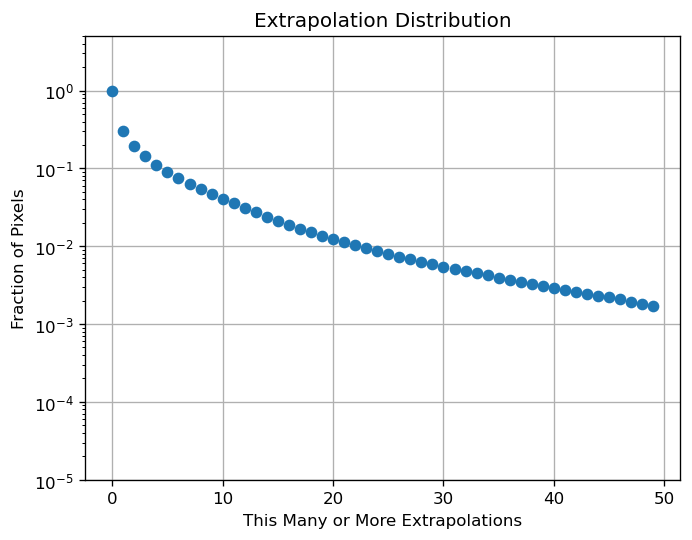

In [19]:
# This is a way to see what percent of pixels have some number of extrapolations or more.
x = np.arange(50)
y = []
for xi in x:
    y.append(len(np.where(allCropExtrMaps >= xi)[0]) / len(allCropExtrMaps))
plt.figure(dpi = 120)
plt.scatter(x, y, zorder = 4)
plt.grid(zorder = 0)
plt.ylim([0.00001, 5])
plt.yscale('log')
plt.ylabel('Fraction of Pixels')
plt.xlabel('This Many or More Extrapolations')
plt.title('Extrapolation Distribution')
plt.show()

In [20]:
# This converts it to a Healsparce map
extrHsp = hsp.HealSparseMap(nside_coverage=32, healpix_map=extrMap)

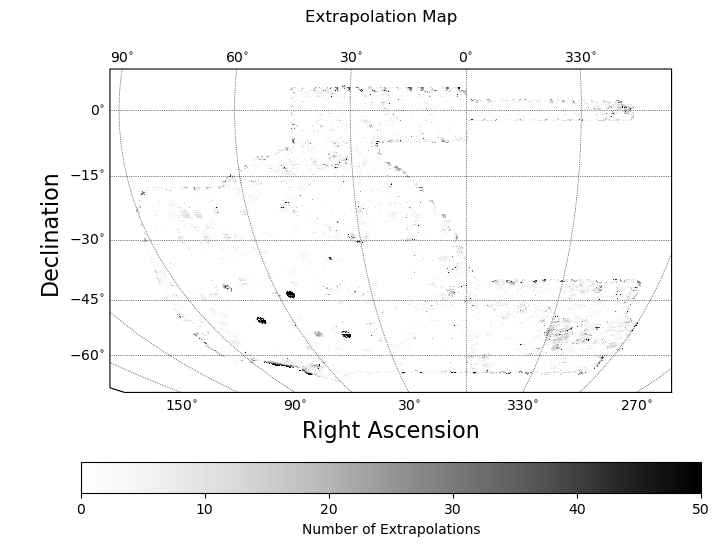

In [21]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(extrHsp, cmap = 'Greys')
plt.clim(0, 50)
plt.colorbar(location = 'bottom', label = 'Number of Extrapolations')
fig.suptitle('Extrapolation Map')
plt.show()

In [22]:
# This generates the fracDet data.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

In [23]:
# This degrades it to 512 resolution and applies a cut to where there is at least 75% coverage.
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
# fracMap = hp.ud_grade(fracMap, 512, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [24]:
# Generates a full map at the desired resolution.
# Corrects for fracDet corrections and masks unwanted points. Next cell does the same for original data.
map512 = np.full(12*(res**2), 0.0)
map512[fracPix] = fullMap[fracPix] / fracMap[fracPix]
map512[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
map512[np.where(extrMap >= 20)[0]] = hp.UNSEEN

In [25]:
origMap512 = np.full(12*(res**2), 0.0)
origMap512[fracPix] = origFullMap[fracPix] / fracMap[fracPix]
origMap512[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
origMap512[np.where(extrMap >= 20)[0]] = hp.UNSEEN

In [26]:
# This will be used to normalize the smoothed functions.
weights = np.full(12*(res**2), 0.0)
weights[np.where(map512 >= 0)[0]] = 1.0

In [27]:
# This generates healsparce maps for the original and corrected maps.
nside_coverage = 32
hspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=map512)
origHspMap512 = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origMap512)

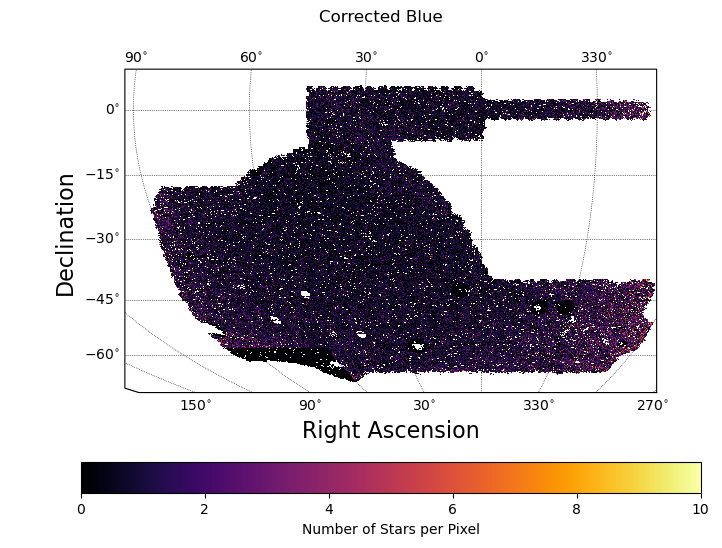

In [30]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspMap512, cmap = 'inferno')
plt.clim(0, 10)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Blue')
plt.show()

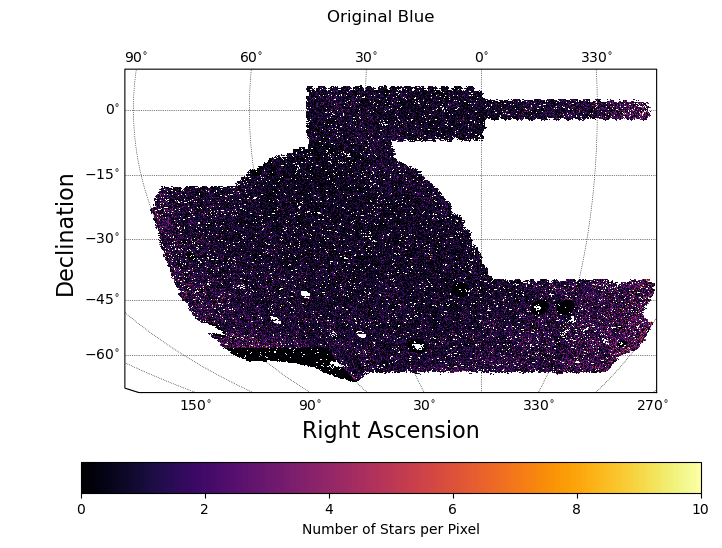

In [31]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(origHspMap512, cmap = 'inferno')
plt.clim(0, 10)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Blue')
plt.show()

In [26]:
# This is the degree of the gaussian kernel used to smooth.
degrees = 2
sig = degrees * np.pi / 180

In [27]:
# Thiis smooths the maps and normalizes them using the weights.
smoothWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(weights, n2r = True), sigma = sig), r2n = True)
smoothMap = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(map512, n2r = True), sigma = sig), r2n = True)
origSmoothMap = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(origMap512, n2r = True), sigma = sig), r2n = True)

smoothMap[np.where(weights == 1)[0]] = smoothMap[np.where(weights == 1)[0]] / smoothWeights[np.where(weights == 1)[0]]
origSmoothMap[np.where(weights == 1)[0]] = origSmoothMap[np.where(weights == 1)[0]] / smoothWeights[np.where(weights == 1)[0]]

smoothMap[np.where(weights == 0)[0]] = hp.UNSEEN
origSmoothMap[np.where(weights == 0)[0]] = hp.UNSEEN

In [29]:
hspSmoothMap = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=smoothMap)
origHspSmoothMap = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origSmoothMap)

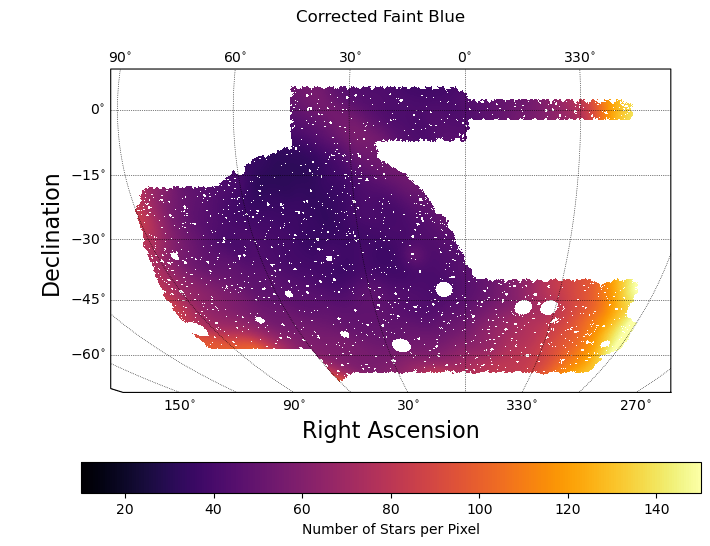

In [30]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspSmoothMap, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Faint Blue')
plt.show()

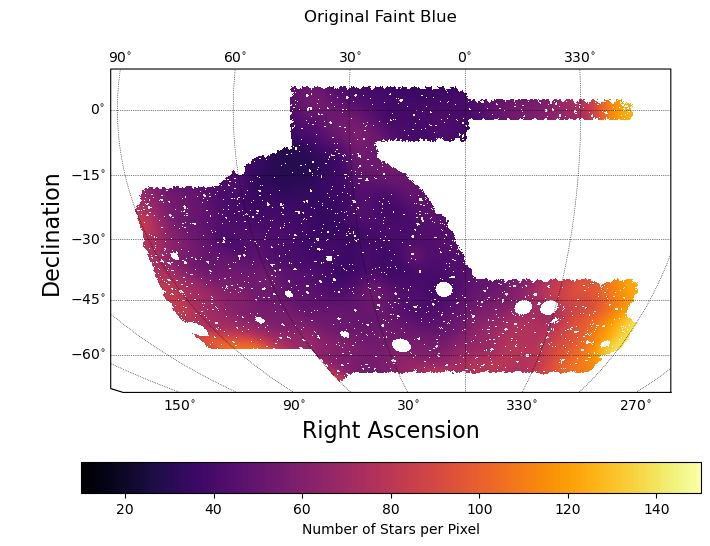

In [31]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(origHspSmoothMap, cmap = 'inferno')
plt.clim(10, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Faint Blue')
plt.show()

In [32]:
# This shows the difference betweent the smoothed and unsmoothed plots.
adjCorr = map512 - smoothMap
adjCorr[np.where(weights == 0)[0]] = hp.UNSEEN

adjOrig = origMap512 - origSmoothMap
adjOrig[np.where(weights == 0)[0]] = hp.UNSEEN

hspAdjCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=adjCorr)
hspAdjOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=adjOrig)

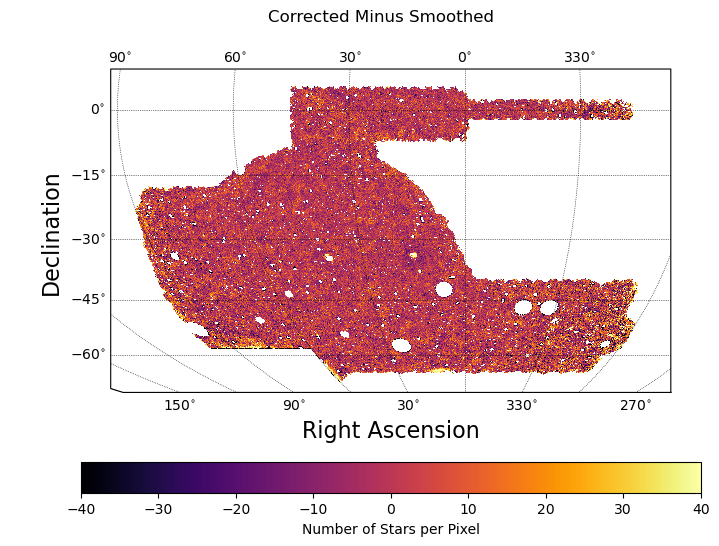

In [33]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspAdjCorr, cmap = 'inferno')
plt.clim(-40, 40)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Corrected Minus Smoothed')
plt.show()

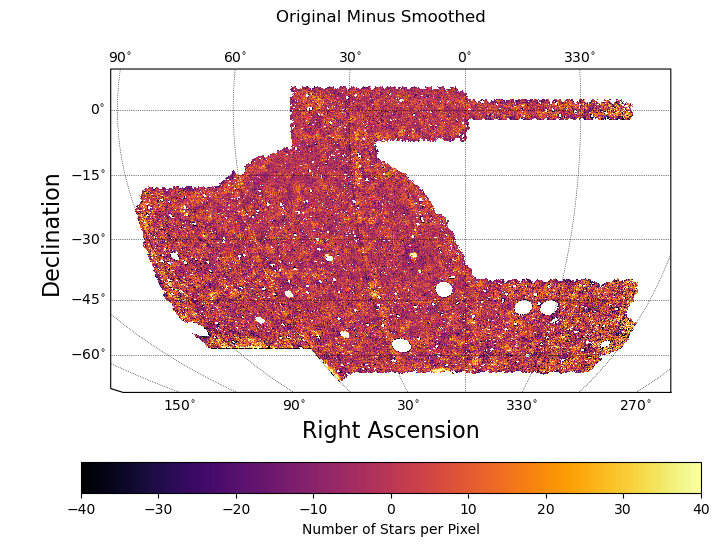

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspAdjOrig, cmap = 'inferno')
plt.clim(-40, 40)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle('Original Minus Smoothed')
plt.show()

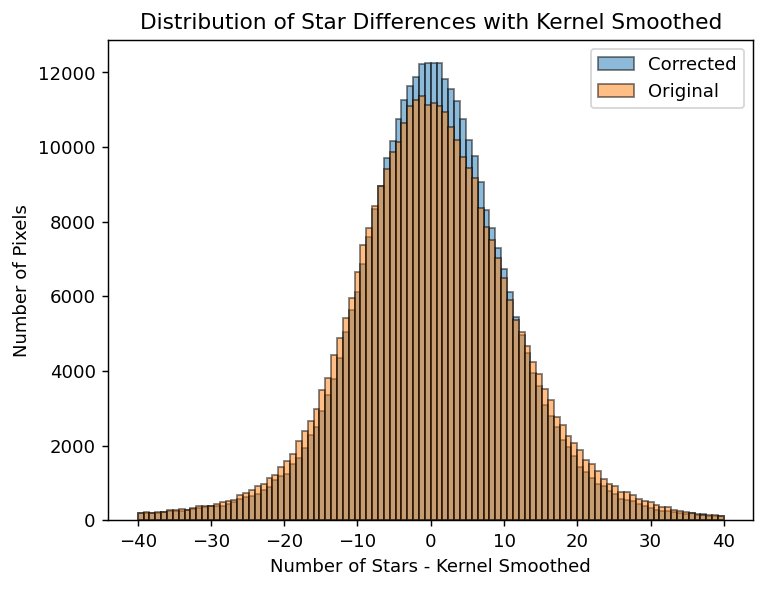

In [ ]:
plt.figure(dpi = 130)
plt.hist(hspAdjCorr[hspAdjCorr.valid_pixels], bins = np.linspace(-40, 40, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Corrected')
plt.hist(hspAdjOrig[hspAdjOrig.valid_pixels], bins = np.linspace(-40, 40, 101), alpha = 0.5, edgecolor = 'black', linewidth = 1, label = 'Original')
plt.legend()
plt.title('Distribution of Star Differences with Kernel Smoothed')
plt.xlabel('Number of Stars - Kernel Smoothed')
plt.ylabel('Number of Pixels')
plt.show()

In [38]:
print(np.std(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(np.std(hspAdjOrig[hspAdjOrig.valid_pixels]))

13.54282624387223
13.647878539070717


In [39]:
print(sc.stats.skew(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(sc.stats.skew(hspAdjOrig[hspAdjOrig.valid_pixels]))

5.205038255088574
4.495548187844457


In [40]:
print(sc.stats.kurtosis(hspAdjCorr[hspAdjCorr.valid_pixels]))
print(sc.stats.kurtosis(hspAdjOrig[hspAdjOrig.valid_pixels]))

328.88273096849275
296.08666101051585


In [36]:
# This would be used to save the corrected and original maps.

# my_table = Table()
# my_table['PIXEL'] = hspMap512.valid_pixels
# my_table['SIGNAL'] = hspMap512[hspMap512.valid_pixels]
# my_table.write(dirTrain + 'Inter_Blue_<=26_Corrected_Map.fits', overwrite = True)

In [37]:
# my_table = Table()
# my_table['PIXEL'] = origHspMap512.valid_pixels
# my_table['SIGNAL'] = origHspMap512[origHspMap512.valid_pixels]
# my_table.write(dirTrain + 'Inter_Blue_<=26_Original_Map.fits', overwrite = True)